In [1]:
# import block
from unifloc.pvt.fluid_flow import FluidFlow
from unifloc.equipment.natural_separation import NaturalSeparation
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve
from tqdm import tqdm

# PVT Properties

In [2]:
# Инициализация исходных данных класса FluidFlow
q_fluid = 100 / 86400
wct = 0
pvt_model_data = {'black_oil': {'gamma_gas': 0.7, 'gamma_wat': 1, 'gamma_oil': 0.8,
                                'rp': 50,
                                'oil_correlations':
                                 {'pb': 'Standing', 'rs': 'Standing',
                                  'rho': 'Standing','b': 'Standing',
                                  'mu': 'Beggs', 'compr': 'Vasquez'},
                    'gas_correlations': {'ppc': 'Standing', 'tpc': 'Standing',
                                         'z': 'Dranchuk', 'mu': 'Lee'},
                    'water_correlations': {'b': 'McCain', 'compr': 'Kriel',
                                           'rho': 'Standing', 'mu': 'McCain'},
                    'rsb': {'value': 50, 'p': 10000000, 't': 303.15},
                    'muob': {'value': 0.5, 'p': 10000000, 't': 303.15},
                    'bob': {'value': 1.5, 'p': 10000000, 't': 303.15},
                    'table_model_data': None, 'use_table_model': False}}

# Инициализация исходных данных метода расчета pvt-свойств флюидов
p = 4 * (10 ** 6)
t = 350

In [3]:
# Инициализация объекта pvt-модели
fluid_flow = FluidFlow(q_fluid, wct, pvt_model_data)

# Пересчет всех свойств для данного давления и температуры
fluid_flow.calc_flow(p, t)

In [4]:
print(f'dens_l = {fluid_flow.rl: .1f} кг/м3\n'
      f'dens_g = {fluid_flow.rg: .1f} кг/м3\n'
      f'sigma = {fluid_flow.stlg: .3f} Н/м\n'
      f'mu_l = {fluid_flow.mul: .3f} сПз\n'
      f'q_l = {fluid_flow.ql: .5f} м3/с\n'
      f'q_g = {fluid_flow.qg: .5f} м3/с\n'
     )

dens_l =  685.2 кг/м3
dens_g =  29.4 кг/м3
sigma =  0.018 Н/м
mu_l =  0.491 сПз
q_l =  0.00137 м3/с
q_g =  0.00122 м3/с



In [5]:
# Инициализация исходных данных
h_mes_ = 1800
d_tub = 0.063
d_cas = 0.130
q_fluid = fluid_flow.ql
q_gas = fluid_flow.qg
sigma_l = fluid_flow.stlg
rho_liq = fluid_flow.rl
rho_gas = fluid_flow.rg

## General use functions

In [6]:
def v_S(qi: float, r_c: float, r_p: float) -> float:
    return qi / (math.pi * (r_c**2 - r_p**2))

In [7]:
def v_s(dens_l: float, dens_g: float, sigma_l: float, g=9.81) -> float:
    # slip or bubble rise velocity
    return 1.53 * (g * sigma_l * (dens_l - dens_g)/(dens_l**2))**(1/4)

# test
print(f'v_s = {v_s(rho_liq, rho_gas, sigma_l) : .3f} m/s')

v_s =  0.191 m/s


# Transition A

In [8]:
def trans_A(v_Sl: float, v_s: float) -> float:
    # v_Sg = f(v_Sl)
    return v_Sl/4 + 0.20 * v_s

### Points for Graph

In [9]:
v_Sliq = np.arange(0, 100, 1/1000)
v_Sliq_for_A = v_Sliq
v_Sgas_for_A = trans_A(v_Sliq, v_s(rho_liq, rho_gas, sigma_l))

# Transition B

### Function for Reynolds number

In [10]:
def re_number(dens_mix: float, v_M: float, d_h: float, mu_mix: float) -> float:
    return dens_mix * v_M * d_h / mu_mix

# test
mu_mix = fluid_flow.mum * 10**(-3)  # Pa * s
d_h = d_cas - d_tub
q_mix = fluid_flow.qm
dens_mix = fluid_flow.rm

print(f'Re = {re_number(dens_mix, v_S(q_mix, d_cas/2, d_tub/2), d_h, mu_mix): .2f}')

Re =  24176.27


### Function for Friction Geometry Number

In [11]:
def find_f_ea(k, eccentricity):
    cosh_eta_i = (k*(1+eccentricity**2) + (1-eccentricity**2))/(2*k*eccentricity)
    cosh_eta_0 = (k*(1-eccentricity**2) + (1+eccentricity**2))/(2*eccentricity)
        
    eta_i = math.acosh(cosh_eta_i)
    eta_0 = math.acosh(cosh_eta_0)

    inf_sum = 0
    for n in range(1, 10**(5)):
        try:
            sum_n = 2*n / (math.exp(2*n*eta_i) - math.exp(2 * n * eta_0))
        except (ZeroDivisionError,OverflowError):
            break
        else:
            inf_sum += sum_n

    A = 1/(eta_0 - eta_i) - 2 * inf_sum
    
    B = 1/4 * (1/(math.sinh(eta_0)**4) - 1/(math.sinh(eta_i)**4))

    phi = (math.cosh(eta_i)/math.sinh(eta_i) - math.cosh(eta_0)/math.sinh(eta_0))**2 * A + B

    f_ea = (4 * (1 - k**2) * (1 - k)**2) / (phi * (math.sinh(eta_0))**4)
    
    return f_ea


print(f'f_ea = {find_f_ea(0.9, 0.000001)}')

f_ea = 22.38365369955195


#### Graph for comparison

100%|█████████████████████████████████████████████████████████████████████████████| 998/998 [00:00<00:00, 34373.61it/s]


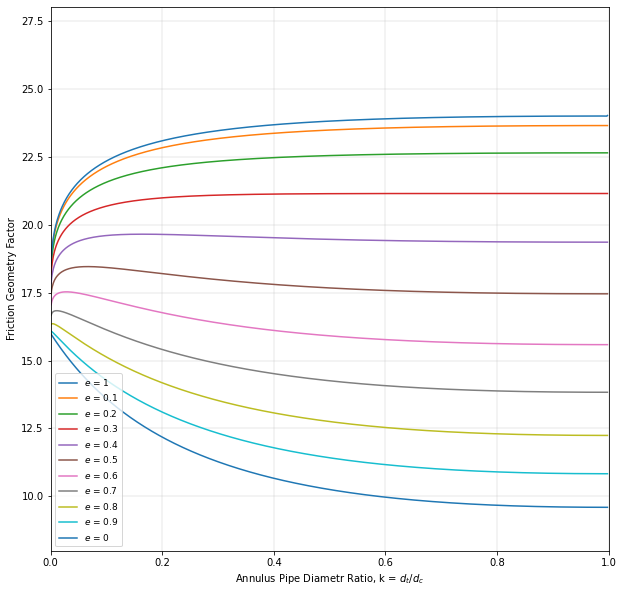

In [12]:
plt.figure(figsize=(10,10))
k = list(np.arange(1/1000, 1 - 1/1000, 1/1000))

# e = (0.1, 1)
legend = []

# e =  1
f_ea_list = []
for i in tqdm(k):
    f_ea_list.append(find_f_ea(i, 0.99999))
plt.plot(k, f_ea_list)
legend.append(f'$e$ = {round(1, 1)}')

for ecc in tqdm(np.arange(0.1, 1, 0.1)):
    f_ea_list = []
    for i in k:
        f_ea_list.append(find_f_ea(i, ecc))
    plt.plot(k, f_ea_list)
    legend.append(f'$e$ = {round(ecc, 1)}')
# print(f_ea_list)


# e =  0
f_ea_list = []
for i in tqdm(k):
    f_ea_list.append(find_f_ea(i, 0.01))
plt.plot(k, f_ea_list)
legend.append(f'$e$ = {round(0, 1)}')

plt.legend(legend, fontsize=9)
plt.xlabel('Annulus Pipe Diametr Ratio, k = $d_t$/$d_c$')
# plt.xscale('log')
plt.ylabel('Friction Geometry Factor')
# plt.yscale('log')

plt.grid(which='both', linewidth=0.3)

plt.ylim([8, 28])
plt.xlim([0, 1])
plt.show()

### Function for Friction Factor

In [13]:
def find_f(r_e: float,  k: float, eccentricity: float, ann_type: str) -> float:
    f_p = 16  # const. value
    
    if ann_type == 'con':
        f_ca = 16 * (1 - k)**2 /((1-k**4)/(1-k**2) - (1-k**2)/math.log(1/k))
#         print(f'f_ca = {f_ca: .2f}')
        
        if r_e <=  2300:  # laminar flow           
            return f_ca / r_e
        
        else:  # turbulent flow
            func_for_f = lambda f: 1/(f*(f_p/f_ca)**(0.45*math.exp(-(r_e-3000)/10**(6))))**(1/2) - (4 * math.log(r_e * 1/(f*(f_p/f_ca)**(0.45*math.exp(-(r_e-3000)/10**(6))))**(1/2), 10) - 0.4)
            return fsolve(func_for_f, 10**(-4))[0]
        
    elif ann_type == 'ecc':
        f_ea = find_f_ea(k, eccentricity)
#         print(f'f_ea = {f_ea: .2f}')
        
        if r_e <=  2300:  # laminar flow
            return f_ea / r_e
        
        else:  # turbulent flow
            func_for_f = lambda f: 1/(f*(f_p/f_ea)**(0.45*math.exp(-(r_e-3000)/10**(6))))**(1/2) - (4 * math.log(r_e * 1/(f*(f_p/f_ea)**(0.45*math.exp(-(r_e-3000)/10**(6))))**(1/2), 10) - 0.4)
            return fsolve(func_for_f, 10**(-4))[0]
    else:
        return 'Err'
    
# test
print('\tconcentric')
print(f'laminar (r_e = 1300): f = {find_f(1300, d_tub/d_cas, 0, ann_type="con"): .4f}')
print(f'trubulent (r_e = 20000): f = {find_f(20000, d_tub/d_cas, 0, ann_type="con"): .4f}')

print('\n\teccentric')
print(f'laminar (r_e = 1300): f = {find_f(1300, d_tub/d_cas, 0.8, ann_type="ecc"): .4f}')
print(f'trubulent (r_e = 20000): f = {find_f(20000, d_tub/d_cas, 0.8, ann_type="ecc"): .4f}')

	concentric
laminar (r_e = 1300): f =  0.0183
trubulent (r_e = 20000): f =  0.0024

	eccentric
laminar (r_e = 1300): f =  0.0098
trubulent (r_e = 20000): f =  0.0018


#### Graph for comparison

In [14]:
re_number_list = list(np.arange(10, 10**6, 100))

f_con_list = []
f_pipe_list = []

for re_n in tqdm(re_number_list):
    f_con_list.append(find_f(re_n, 0.553, 0.8, ann_type="con"))
    f_pipe_list.append(find_f(re_n, 0.553, 0.6, ann_type="ecc"))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2161.33it/s]


In [15]:
f_ecc_list = []
for re_n in tqdm(re_number_list):
    f_ecc_list.append(find_f(re_n, 0.553, 0.999, ann_type="ecc"))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.04it/s]


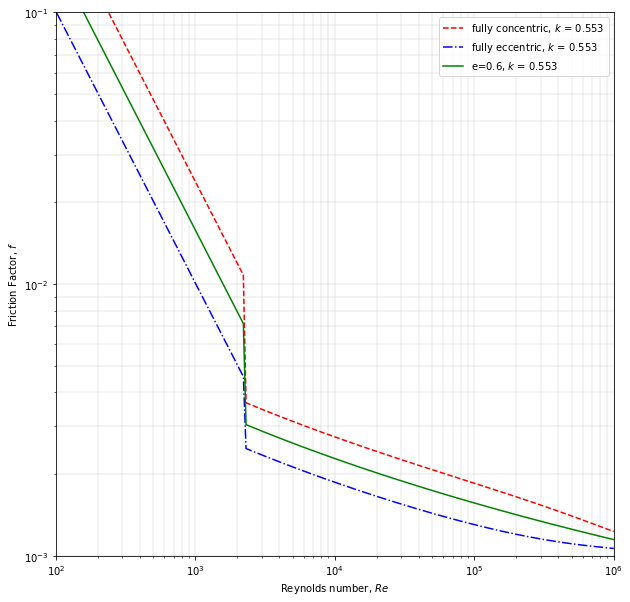

In [16]:
plt.figure(figsize=(10,10))
    
plt.plot(re_number_list, f_con_list, 'r--')
plt.plot(re_number_list, f_ecc_list, 'b-.')
plt.plot(re_number_list, f_pipe_list, 'g')

plt.legend(['fully concentric, $k$ = 0.553', 'fully eccentric, $k$ = 0.553', 'e=0.6, $k$ = 0.553'], fontsize=10)
plt.xlabel('Reynolds number, $Re$')
plt.xscale('log')
plt.ylabel('Friction Factor, $f$')
plt.yscale('log')

plt.grid(which='both', linewidth=0.3)

plt.ylim([10**(-3), 10**(-1)])
plt.xlim([10**(2), 10**(6)])
plt.show()

### Trans. Equation

In [17]:
def trans_B(dens_l: float, dens_g: float, sigma_l: float, v_M: float, f: float, d_h: float, g=9.81) -> float:
    # v_Sg = f(v_M)
    # d_h = d_c - d_t
    A = 2 * (0.4 * sigma_l / ((dens_l-dens_g)*g))**(1/2) * (dens_l/sigma_l)**(3/5) * (2/d_h)**(2/5) * f**(2/5)
    B = ((A) * v_M**(6/5) - 0.725)/4.15
    return v_M * (B)**2

### Points for Graph

In [34]:
k = d_tub/d_cas
r_c = d_cas/2
r_t = d_tub/2
d_h = d_cas - d_tub

v_Sliq = np.arange(0.001, 100, 1/100)
v_Sliq_new_for_B = []
v_Sgas_for_B = []

for v in v_Sliq:
    q_fluid_i = v * (math.pi * (r_c**2 - r_t**2))
#     print(f'q_fluid_i = {q_fluid_i}')
    
    fluid_flow_i = FluidFlow(q_fluid_i, wct, pvt_model_data)
    fluid_flow_i.calc_flow(p, t)
    
    rho_liq_i = fluid_flow_i.rl
    rho_gas_i = fluid_flow_i.rg
    sigma_l_i = fluid_flow_i.stlg
#     if not sigma_l_i:
#         sigma_l_i = 0.018
    q_mix_i = fluid_flow_i.qm
    dens_mix_i = fluid_flow_i.rm
    mu_mix_i = fluid_flow_i.mum * 10**(-3)
#     print(f'rho_liq_i = {rho_liq_i}')
#     print(f'rho_gas_i = {rho_gas_i}')
#     print(f'sigma_l_i = {sigma_l_i}')
#     print(f'q_mix_i = {q_mix_i}')
#     print(f'dens_mix_i = {dens_mix_i}')
#     print(f'mu_mix_i = {mu_mix_i}')
    
    v_mix_i = v_S(q_mix_i, r_c, r_t)
#     print(f'v_mix_i = {v_mix_i}')

    r_e_i = re_number(dens_mix_i, v_mix_i, d_h, mu_mix_i)
#     print(f'r_e_i = {r_e_i}')

    f_i = find_f(r_e_i, k, 0.8, ann_type="con")
#     print(f'f_i = {f_i}')
    
    v_Sg_i = trans_B(rho_liq_i, rho_gas_i, sigma_l_i, v_mix_i, f_i, d_h)
    
#     if (v_Sg_i >= 0.01) and not (abs(0 - v) <= 10**(-5)):
    v_Sliq_new_for_B.append(v)
    v_Sgas_for_B.append(v_Sg_i) 
#     print(f'v_Sg = {v_Sg_i: .4f}\n')
    
print(len(v_Sgas_for_B))

i = v_Sgas_for_B.index(min(v_Sgas_for_B))

v_Sliq_new_for_B = v_Sliq_new_for_B[i:]
v_Sgas_for_B = v_Sgas_for_B[i:]

10000


# Transition C

In [35]:
def trans_C(v_Sl: float, v_s: float) -> float:
    # v_Sg = f(v_Sl)
    return 1.083*v_Sl + 0.52 * v_s

### Points for Graph

In [36]:
v_Sliq = np.arange(0, 100, 1/1000)
v_Sliq_for_C = v_Sliq
v_Sgas_for_C = trans_C(v_Sliq, v_s(rho_liq, rho_gas, sigma_l))

# Transition D

In [37]:
def trans_D(dens_l: float, dens_g: float, sigma_l: float, g=9.81) -> float:
    return 3.1 * (g * sigma_l * (dens_l - dens_g)/(dens_l**2))**(1/4)

### Points for Graph

In [38]:
v_Sgas_for_D = [trans_D(rho_liq, rho_gas, sigma_l), trans_D(rho_liq, rho_gas, sigma_l)]
v_Sliq_for_D = [0, 100]

# Flow pattern Map

### Finding intersection points

In [39]:
from shapely.geometry import LineString

In [40]:
line_B = LineString(np.column_stack((v_Sgas_for_B, v_Sliq_new_for_B)))
line_A = LineString(np.column_stack((v_Sgas_for_A, v_Sliq_for_A)))
intersection_AB = line_B.intersection(line_A)

print(intersection_AB.xy[0][0], intersection_AB.xy[1][0])

line_C = LineString(np.column_stack((v_Sgas_for_C, v_Sliq_for_C)))
intersection_CB = line_B.intersection(line_C)

print(intersection_CB.xy[0][0], intersection_CB.xy[1][0])

0.5652526031722375 2.1082419316817314
3.738090031597803 3.3599173766787733


In [41]:
val_for_Ag = intersection_AB.xy[0][0]

absolute_difference_function_A = lambda list_value : abs(list_value - val_for_Ag)

closest_value_for_A = min(list(v_Sgas_for_A), key=absolute_difference_function_A)

print(closest_value_for_A)

lim_A = list(v_Sgas_for_A).index(closest_value_for_A)

print(f'lim_A = {lim_A}')

0.5651921202518047
lim_A = 2108


In [42]:
val_for_Cg = intersection_CB.xy[0][0]

absolute_difference_function_C = lambda list_value : abs(list_value - val_for_Cg)

closest_value_for_C = min(list(v_Sgas_for_C), key=absolute_difference_function_C)

print(closest_value_for_C)

lim_C = list(v_Sgas_for_C).index(closest_value_for_C)

print(f'lim_C = {lim_C}')

3.7381795126546917
lim_C = 3360


In [43]:
val_for_Bg = intersection_CB.xy[0][0]

absolute_difference_function_B = lambda list_value : abs(list_value - val_for_Bg)

closest_value_for_B = min(list(v_Sgas_for_B), key=absolute_difference_function_B)

print(closest_value_for_B)

lim_B = list(v_Sgas_for_B).index(closest_value_for_B)

print(f'lim_B = {lim_B}')

3.7426580190785588
lim_B = 256


### Flow predictions logic functions

#### Bubble fow existance

In [44]:
d_ep = d_cas + d_tub

def check_if_bubble_flow(dens_l, dens_g, sigma_l, d_ep, g=9.81) -> bool:
    # checks if the bubble flow pattern region in annuli exists
    return d_ep >= 19.7 * ((dens_l - dens_g) * sigma_l / (g * dens_l**2))**(1/2)

# test
print(f'the bubble flow pattern region in annuli exists : {check_if_bubble_flow(rho_liq, rho_gas, sigma_l, d_ep)}')

the bubble flow pattern region in annuli exists : True


#### Check if annular flow is present

In [45]:
def check_if_annular_flow(v_Sg: float, dens_l: float, dens_g: float, sigma_l: float) -> bool:
    return v_Sg >= trans_D(dens_l, dens_g, sigma_l)

# test
print(f'the annular flow pattern region in annuli exists : {check_if_annular_flow(v_S(q_gas, d_cas/2, d_tub/2), rho_liq, rho_gas, sigma_l)}')
print(f'the annular flow pattern region in annuli exists : {check_if_annular_flow(0.4, rho_liq, rho_gas, sigma_l)}')

the annular flow pattern region in annuli exists : False
the annular flow pattern region in annuli exists : True


#### Check if dispersed bubble flow

In [46]:
def check_if_disp_bubble(v_Sl: float, v_Sg: float, dens_l: float, dens_g: float, sigma_l: float, dens_mix: float,
                         mu_mix: float, d_tub: float, d_cas: float, ann_type: str, eccentricity: float) -> bool:
    k = d_tub/d_cas
    d_h = d_cas - d_tub
    v_mix = v_Sl + v_Sg
    r_e = re_number(dens_mix, v_mix, d_h, mu_mix)
    f = find_f(r_e,  k, eccentricity, ann_type)
    v_slip = v_s(dens_l, dens_g, sigma_l)
    
    # above C trans
    above_C = v_Sg <= trans_C(v_Sl, v_slip)
    # above B trans
    above_B = v_Sg <= trans_B(dens_l, dens_g, sigma_l, v_mix, f, d_h)
    return (above_C and above_B)

# test
v_Sl1_test = v_S(q_fluid, d_cas/2, d_tub/2)
v_Sg1_test = v_S(q_gas, d_cas/2, d_tub/2)
print(f"the dispersed bubble flow pattern region in annuli exists : {check_if_disp_bubble(v_Sl1_test, v_Sg1_test, rho_liq, rho_gas, sigma_l, dens_mix, mu_mix, d_tub, d_cas, ann_type='con', eccentricity=0.8)}")

the dispersed bubble flow pattern region in annuli exists : False


#### Check if in bubble fow area

In [47]:
def check_ifin_bubble(v_Sl: float, v_Sg: float, dens_l: float, dens_g: float, sigma_l: float, dens_mix: float,
                      mu_mix: float, d_tub: float, d_cas: float, ann_type: str, eccentricity: float) -> bool:
    k = d_tub/d_cas
    d_h = d_cas - d_tub
    v_mix = v_Sl + v_Sg
    r_e = re_number(dens_mix, v_mix, d_h, mu_mix)
    f = find_f(r_e,  k, eccentricity, ann_type)
    v_slip = v_s(dens_l, dens_g, sigma_l)
    
    # above A trans
    above_A = v_Sg <= trans_A(v_Sl, v_slip)
    # below B trans
    below_B = v_Sg >= trans_B(dens_l, dens_g, sigma_l, v_mix, f, d_h)
    return (above_A and below_B)

# test
v_Sl2_test = v_S(q_fluid, d_cas/2, d_tub/2)
v_Sg2_test = v_S(q_gas, d_cas/2, d_tub/2)
print(f"the dispersed bubble flow pattern region in annuli exists : {check_ifin_bubble(v_Sl2_test, v_Sg2_test, rho_liq, rho_gas, sigma_l, dens_mix, mu_mix, d_tub, d_cas, ann_type='con', eccentricity=0.8)}")

the dispersed bubble flow pattern region in annuli exists : False


#### Check if slug or chutn flow

In [48]:
def check_if_slug(v_Sl: float, v_Sg: float, dens_l: float, dens_g: float, sigma_l: float, dens_mix: float,
                      mu_mix: float, d_tub: float, d_cas: float, ann_type: str, eccentricity: float,
                      v_Sl_CB_inter: float) -> bool:
    k = d_tub/d_cas
    d_h = d_cas - d_tub
    v_mix = v_Sl + v_Sg
    r_e = re_number(dens_mix, v_mix, d_h, mu_mix)
    f = find_f(r_e,  k, eccentricity, ann_type)
    v_slip = v_s(dens_l, dens_g, sigma_l)
    if v_Sl < v_Sl_CB_inter:
        below_A = v_Sg >= trans_A(v_Sl, v_slip)
        below_B = v_Sg >= trans_B(dens_l, dens_g, sigma_l, v_mix, f, d_h)
        return (below_A and below_B)
    
    else:
        below_S = v_Sg >= trans_C(v_Sl, v_slip)
        return below_S
    
# test
v_Sl3_test = v_S(q_fluid, d_cas/2, d_tub/2)
v_Sg3_test = v_S(q_gas, d_cas/2, d_tub/2)
print(f"the slug or chutn flow pattern region in annuli exists : {check_if_slug(v_Sl3_test, v_Sg3_test, rho_liq, rho_gas, sigma_l, dens_mix, mu_mix, d_tub, d_cas, 'con', 0.8, intersection_CB.xy[1][0])}")

the slug or chutn flow pattern region in annuli exists : True


### Plotting

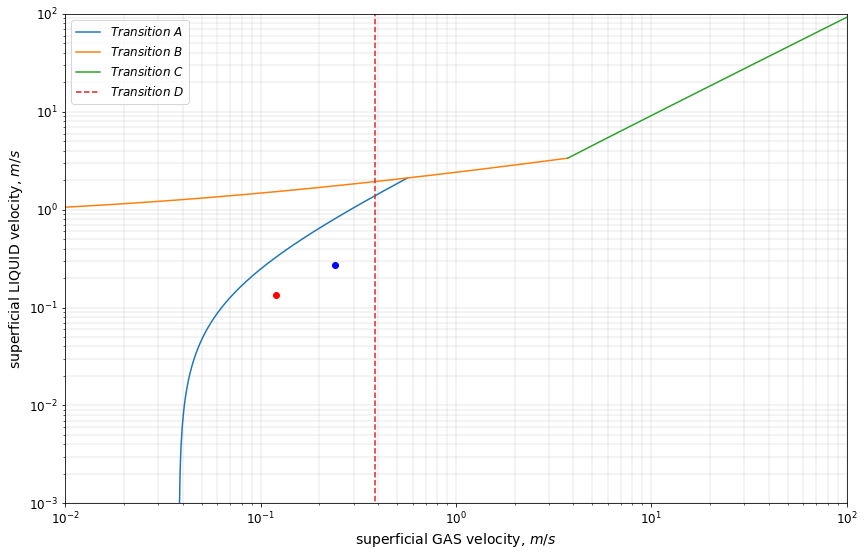

In [51]:
# PLOT
plt.figure(figsize=(14,9))

# A
plt.plot(v_Sgas_for_A[:lim_A], v_Sliq_for_A[:lim_A])
# B
plt.plot(v_Sgas_for_B[:lim_B], v_Sliq_new_for_B[:lim_B])
# C
plt.plot(v_Sgas_for_C[lim_C:], v_Sliq_for_C[lim_C:])
# D
plt.plot(v_Sgas_for_D, v_Sliq_for_D, '--')

# test
# q = 100
plt.scatter(0.11986040573847151, 0.13496805289069724, color='red')
# 
plt.scatter(0.23984240135304072, 0.27007302129346056, color='blue')

#
# plt.scatter(intersection_AB.xy[0][0], intersection_AB.xy[1][0], color='purple')
# plt.plot([inter_AB[0]+inter_AB[1], inter_AB[0]+inter_AB[1]], [0, 100], '--')

#
# plt.scatter(intersection_CB.xy[0][0], intersection_CB.xy[1][0], color='red')
# plt.plot([inter_CB[0]+inter_CB[1], inter_CB[0]+inter_CB[1]], [0, 100], '--')

plt.legend(['$Transition$ $A$', '$Transition$ $B$','$Transition$ $C$', '$Transition$ $D$'], fontsize=12)
plt.xlabel('superficial GAS velocity, $m$/$s$', fontsize=14)
plt.xscale('log')
plt.ylabel('superficial LIQUID velocity, $m$/$s$', fontsize=14)
plt.yscale('log')

plt.tick_params(axis='both', which='major', labelsize=12)

plt.grid(which='both', linewidth=0.3)

plt.ylim([0.001, 100])
plt.xlim([0.01, 100])
plt.show()